In [1]:
import warnings
import datetime
import itertools
import numpy as np
import scipy as sp
import cvxpy as cp
import pandas as pd
import yfinance as yf
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
from functools import reduce
from kit import interval_dict, annualize_returns, annualize_vol, get_yf_ts, get_usd_mcap, gbm

warnings.filterwarnings('ignore')

This notebook does very simple dividends analysis on liquid single stock names primarily in the US.

A <b>dividend</b> is a distribution of profits by a corporation to its shareholders. When a corporation earns a profit or surplus, it is able to pay a portion of the profit as a dividend to shareholders. Dividends are commonly paid in cash to the shareholder and sometimes the amount can be paid in further shares if the company operates a dividend reinvestment plan.

Public companies usually pay dividends on a fixed schedule called <b>ordinary dividends</b>, but may sometimes cancel a scheduled dividend, or declare <b>an unscheduled dividend, called a special dividend</b>. Usually when a company raises the amount of its normal dividend, the investor expectation is that this marks a sustained increase. In the case of a special dividend, however, the company is signalling that this is a one-off payment. Special dividends are normally paid on extraordinary events for the company, for instance outperforming profit projections, mergers with other companies, release of new products etc.

In [111]:
def get_dividends(ticker, start_year, end_year=datetime.date.today().year):
    df = yf.Ticker(ticker).get_dividends().to_frame()
    df.index = df.index.to_period('D').to_timestamp()
    return df[str(start_year) : str(end_year)].rename(columns={'Dividends' : '{}_DIV'.format(ticker)})

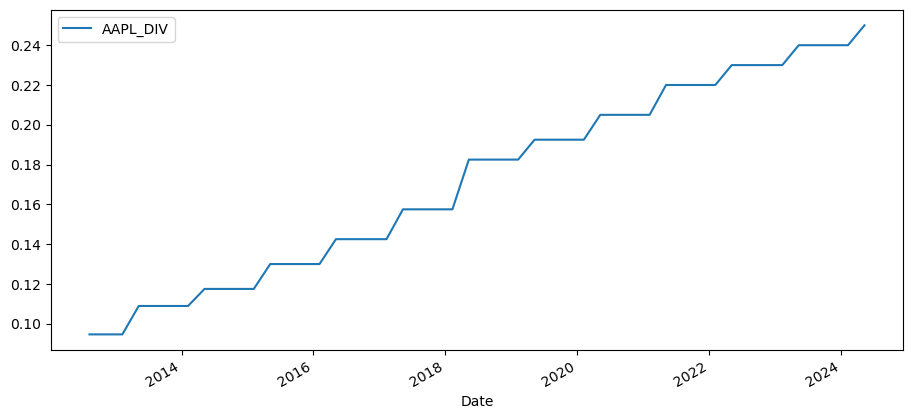

In [159]:
aapl_div = get_dividends('AAPL', 2000, 2024) # Here we obtain both special and ordinary dividends

aapl_div.plot(figsize=(11,5))
plt.show()

There are multiple dates that concern dividends with 3 being the most important:
1. <b>Announcement date</b> - when the board of directors announces a future dividend payment. On that day, a liability is created and the company records that liability on its books; it now owes the money to the shareholders.
2. <b>Ex-dividend date</b> - shareholders holding the stock on that date get paid the dividend amount. Note, trades on that date are excluded from dividends, so it's technically T-1 of this date. ** This is the date we receive from Yahoo Finance **
3. <b>Payment date</b> - date on which the dividend amount will be transferred.

<b>Dividend frequency</b> is the number of dividend payments within a year. For our AAPL example below, we observe that it normally pays dividends 4 times a year (quarterly):

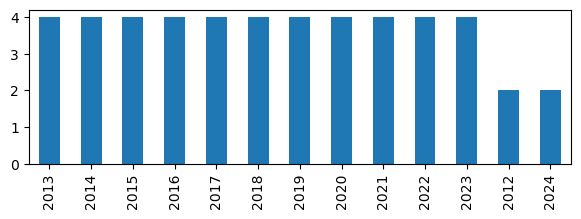

In [126]:
aapl_div.index.year.value_counts().plot.bar(figsize=(7, 2))
plt.show()

<b>Dividend tax</b> is a tax imposed by a jurisdiction on a shareholder for dividend proceeds. A dividend tax is in addition to any tax imposed directly on the corporation on its profits. Some jurisdictions do not tax dividends, or have lower tax rates for stocks incorporated in that jurisdiction. It is a common practice for investors to transfer ownership of the stock during dividend periods to other investors in jurisdictions where tax rates are lower. That is typically done via derivative instruments such as swaps.

<b>Dividend yield</b> is a ratio that shows how much a company (or investment fund) pays out in dividends relative to its share price. It is annualized, and it technically shows the dividend gain on the investment.

In [133]:
aapl_price = get_yf_ts('AAPL', '10y', '1d')
aapl_price.index = aapl_price.index.to_timestamp()
aapl = aapl_price.merge(aapl_div, left_index=True, right_index=True)
aapl['year'] = aapl.index.year
aapl_div_agg = aapl.groupby('year').agg({'AAPL_DIV' : 'sum', 'AAPL' : 'last'})
aapl_div_agg['DIV_YIELD'] = aapl_div_agg['AAPL_DIV'] / aapl_div_agg['AAPL']

For our example of AAPL, we see how the dividend yield is on a downwards trend, possibly making the stock less attractive to income focused investors. In 2016 it peaked at 2.2% dividend return, whereas now is at 0.5%.

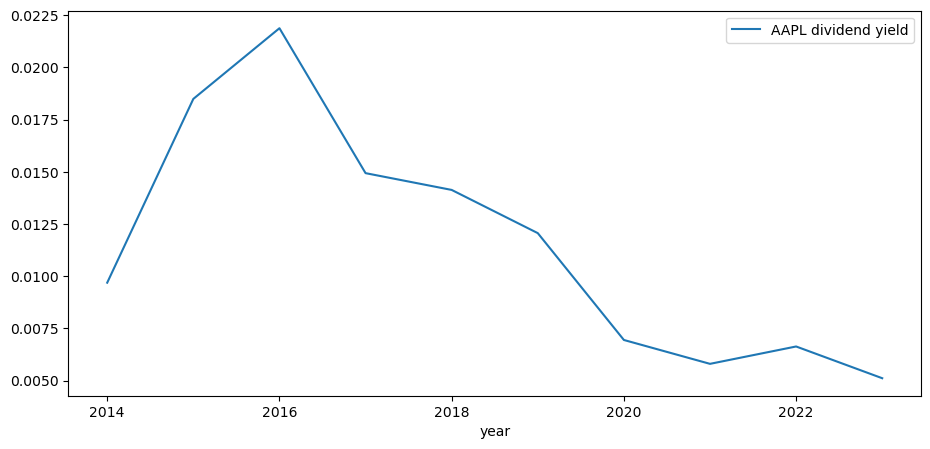

In [147]:
aapl_div_agg.loc[2014:2023].DIV_YIELD.plot(figsize=(11,5), label='AAPL dividend yield')
plt.legend()
plt.show()

<b>Special dividends</b> as mentioned before are paid as a one-off during extraordinary events for the company, typically, when the company has exceptionally strong earnings that it wishes to distribute to shareholders. One prominent example of this is a special dividend announced by Microsoft in 2004 at 3.08, to partially relieve its balance sheet of a large cash balance.

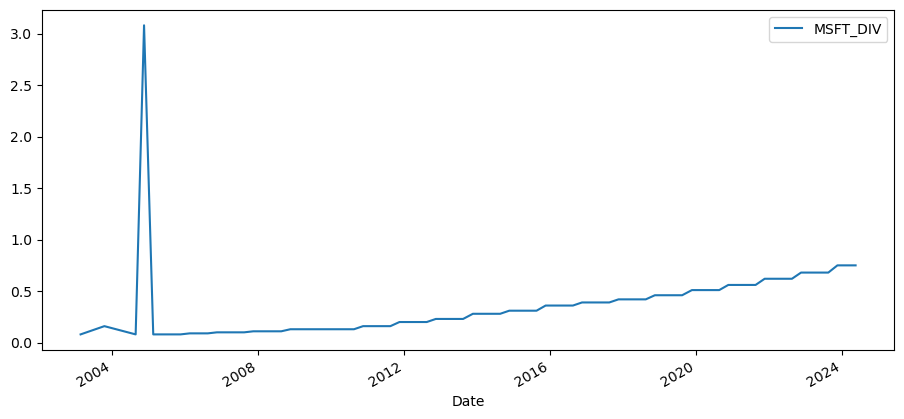

In [158]:
get_dividends('MSFT', 2000).plot(figsize=(11,5))
plt.show()